In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.quantum_info import Z2Symmetries, SparsePauliOp, Operator, Pauli
driver = PySCFDriver(
    atom="He 0 0 0; H+ 0 0 0.772",
    basis="sto-3g",
    charge=1,
    spin=0,
)

problem = driver.run()
#print(problem)

In [2]:
fermionic_op = problem.hamiltonian.second_q_op()
#print(fermionic_op)
print('spatial orbitals: ', problem.num_spatial_orbitals)
print('spin orbitals: ', problem.num_spin_orbitals)
print('num particles: ', problem.num_particles)


spatial orbitals:  2
spin orbitals:  4
num particles:  (1, 1)


### Pauli Operators 

In [3]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from IPython.display import display, Math

mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
print(qubit_jw_op)
# Convert the operator to a matrix
operator = Operator(qubit_jw_op)
matrix = operator.data

# Function to convert a matrix to a LaTeX string
def matrix_to_latex(matrix, chunk_size=10):
    latex_str = "\\begin{bmatrix}\n"
    for i, row in enumerate(matrix):
        latex_str += " & ".join([f"{elem:.3f}" for elem in row]) + " \\\\\n"
        if (i + 1) % chunk_size == 0:
            latex_str += "\\end{bmatrix}\n\\begin{bmatrix}\n"
    latex_str += "\\end{bmatrix}"
    return latex_str

# Convert the matrix to a LaTeX string in chunks
latex_str = matrix_to_latex(matrix)

# Display the LaTeX string
display(Math(latex_str))

Operator(qubit_jw_op).draw('latex')


SparsePauliOp(['IIII', 'IIIZ', 'IIYY', 'IIXX', 'IIZI', 'IZII', 'YYII', 'XXII', 'ZIII', 'IIZZ', 'IZIZ', 'YYIZ', 'XXIZ', 'ZIIZ', 'IZYY', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-2.91290137+0.j,  0.75891361+0.j,  0.05246557+0.j,  0.05246557+0.j,
  0.19140054+0.j,  0.75891361+0.j,  0.05246557+0.j,  0.05246557+0.j,
  0.19140054+0.j,  0.12887694+0.j,  0.23578727+0.j,  0.04322997+0.j,
  0.04322997+0.j,  0.16528642+0.j,  0.04322997+0.j,  0.04322997+0.j,
  0.03640948+0.j,  0.03640948+0.j,  0.03640948+0.j,  0.03640948+0.j,
 -0.00923466+0.j, -0.00923466+0.j,  0.16528642+0.j, -0.00923466+0.j,
 -0.00923466+0.j,  0.18815906+0.j,  0.12887694+0.j])


<IPython.core.display.Math object>

<IPython.core.display.Latex object>

### Reduce Operator

In [4]:

def reduce_operator(op, reduced=False):
    if reduced:
        z2_symmetries = Z2Symmetries.find_z2_symmetries(op)
        newOp = Z2Symmetries(z2_symmetries.symmetries, z2_symmetries.sq_paulis, z2_symmetries.sq_list)
        tapered_ops = newOp.taper(op)
        print(tapered_ops)
        first_tapered_op = tapered_ops[1]
        return first_tapered_op
    else:
        return op
    
operator = reduce_operator(qubit_jw_op, reduced=True)


#print('sq_list: ',Z2Symmetries.find_z2_symmetries(qubit_jw_op).sq_list)
#print('sq_paulis: ',Z2Symmetries.find_z2_symmetries(qubit_jw_op).sq_paulis)
#print('Symmetries: ',Z2Symmetries.find_z2_symmetries(qubit_jw_op).symmetries)

Operator(operator).draw('latex')


[SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-2.65514749+0.j,  0.95031416+0.j,  0.95031416+0.j,  0.75451917+0.j]), SparsePauliOp(['II', 'IZ', 'ZI', 'XI', 'ZZ', 'XZ'],
              coeffs=[-2.91290137+0.j,  0.95031416+0.j, -0.56751307+0.j, -0.10493114+0.j,
 -0.04762822+0.j, -0.06799062+0.j]), SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'ZZ', 'ZX'],
              coeffs=[-2.91290137+0.j, -0.56751307+0.j, -0.10493114+0.j,  0.95031416+0.j,
 -0.04762822+0.j, -0.06799062+0.j]), SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XZ', 'ZX', 'XX'],
              coeffs=[-3.17065525+0.j, -0.56751307+0.j, -0.10493114+0.j, -0.56751307+0.j,
 -0.10493114+0.j,  0.09337348+0.j,  0.10492927+0.j,  0.10492927+0.j,
  0.14563793+0.j])]


<IPython.core.display.Latex object>

In [5]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "parameters": [],
}



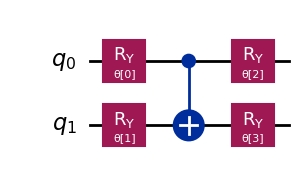

In [6]:
from qiskit_algorithms.optimizers import SLSQP,SPSA,COBYLA, L_BFGS_B
from qiskit_algorithms import VQE
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
ansatz = RealAmplitudes(operator.num_qubits, reps=1)
optimizer = SLSQP()
ansatz.decompose().draw('mpl')

In [7]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = parameters
    cost_history_dict["cost_history"].append(cost)
    cost_history_dict["parameters"].append(parameters)
    return cost

In [8]:
from scipy.optimize import minimize
import numpy as np
initial_params = np.random.uniform(low= -np.pi, high=np.pi, size=ansatz.num_parameters)

In [9]:
result = minimize(cost_func_vqe, initial_params, args=(ansatz, operator, estimator), method="COBYLA",options={'maxiter': 12000})
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.3844111168775655
       x: [-3.880e+00  1.571e+00  7.382e-01 -1.500e+00]
    nfev: 78
   maxcv: 0.0


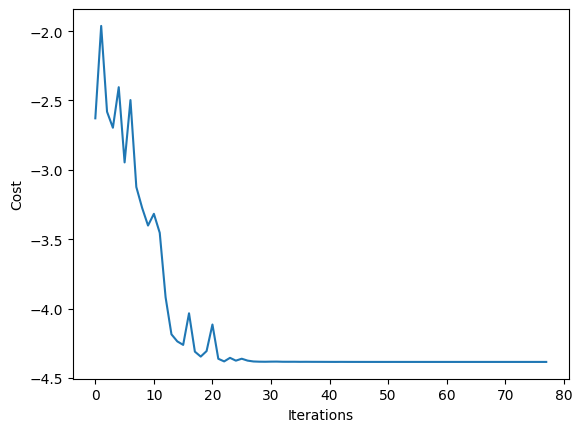

In [10]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

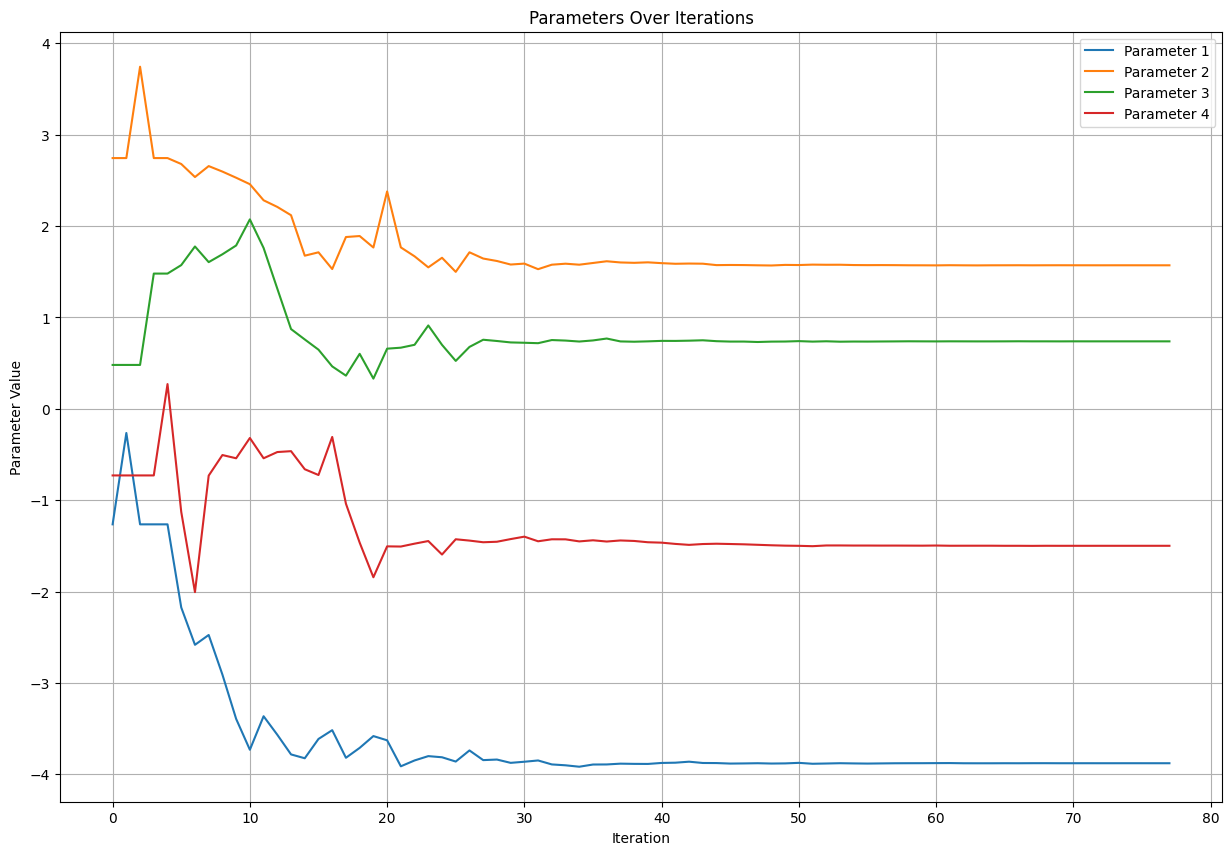

In [11]:
# Extract parameters
param_numbers = ansatz.num_parameters
data2 = cost_history_dict["parameters"]
iterations = range(len(data2))
# Extract all 16 parameters
parameters = [[row[i] for row in data2] for i in range(param_numbers)]
# Plotting the parameters
plt.figure(figsize=(15, 10))
# Plot each parameter
for i in range(param_numbers):
    plt.plot(iterations, parameters[i], label=f'Parameter {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

### Constructing the circuit from the O Malley paper (Fig 1) and calculate the molecular energy at the R = 0.75

In [12]:
g0 = -0.4804
g1 = 0.3435
g2 = -0.4347
g3 = 0.5716
g4 = 0.091
g5 = 0.091

print('g0 + g1 + g2 + g3 = ', g0 + g1 + g2 + g3)
print('g0 + g1 - g2 - g3 = ', g0 + g1 - g2 - g3)
print('g0 - g1 + g2 - g3 = ', g0 - g1 + g2 - g3)
print('g0 - g1 - g2 + g3 = ', g0 - g1 - g2 + g3)
print('g5 + g4 = ', g5 + g4)
print('g5 - g4 = ', g5 - g4)    

matrix = np.array([[g0 + g1 + g2 + g3, 0 , 0 , g5 - g4],
                   [0, g0 + g1 - g2 - g3, g5 + g4, 0],
                   [0, g5 + g4, g0 - g1 + g2 - g3, 0],
                   [g5 - g4, 0, 0, g0 - g1 - g2 + g3]])
observable = SparsePauliOp.from_operator(Operator(matrix))

# this is the alternative way to create the observable
observable_2 = SparsePauliOp.from_list([('II', g0), ('ZI', g1), ('IZ', g2), ('ZZ', g3), ('XX', g5), ('YY', g4)])
Operator(observable_2).draw('latex')

g0 + g1 + g2 + g3 =  1.1102230246251565e-16
g0 + g1 - g2 - g3 =  -0.2738
g0 - g1 + g2 - g3 =  -1.8302
g0 - g1 - g2 + g3 =  0.1823999999999999
g5 + g4 =  0.182
g5 - g4 =  0.0


<IPython.core.display.Latex object>

In [13]:
#Operator(observable).draw('latex')

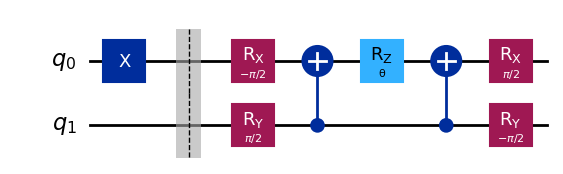

In [14]:
from qiskit import QuantumCircuit

from qiskit.circuit import Parameter
import numpy as np
pi = np.pi
theta = Parameter('θ')
param1 = pi/2
param2 = -pi/2
qc = QuantumCircuit(2)

# qc.unitary(Operator(observable),[0,1])

qc.x(0)
qc.barrier()
qc.rx(param2,0)
qc.ry(param1,1)

qc.cx(1,0)

qc.rz(theta,0)

qc.cx(1,0)

qc.ry(param2,1)
qc.rx(param1,0)
qc.draw('mpl')



### Deconstructing the circuit

In [15]:
# First part - the reference state

qc_1 = QuantumCircuit(2)
qc_1.x(1)

qc_1_op = Operator.from_circuit(qc_1)

qc_1_op.draw('latex')

<IPython.core.display.Latex object>

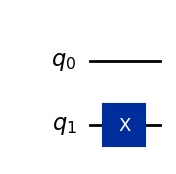

In [16]:
qc_1.draw('mpl')


# the second part - the ansatz

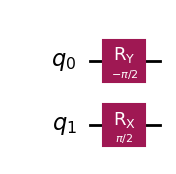

In [17]:
qc_2 = QuantumCircuit(2)

qc_2.ry(param2,0)
qc_2.rx(param1,1)
qc_2.draw('mpl')


In [18]:
qc_2_op = Operator.from_circuit(qc_2)
qc_2_op.draw('latex')

<IPython.core.display.Latex object>

In [19]:
initial_params_h2 = np.random.uniform(low= -np.pi, high=np.pi, size=qc.num_parameters)

In [20]:
print('initial_params_h2: ', initial_params_h2)

initial_params_h2:  [2.382628]


In [21]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "parameters": [],
}

In [22]:
result = minimize(cost_func_vqe, initial_params_h2, args=(qc, observable_2, estimator), method="COBYLA",options={'maxiter': 12000})
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8511991179724716
       x: [ 2.912e+00]
    nfev: 24
   maxcv: 0.0


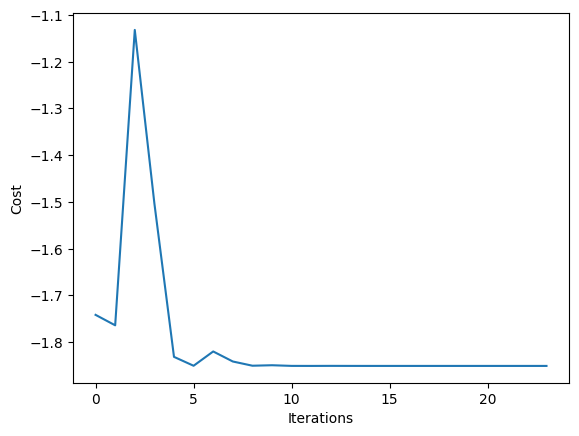

In [23]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

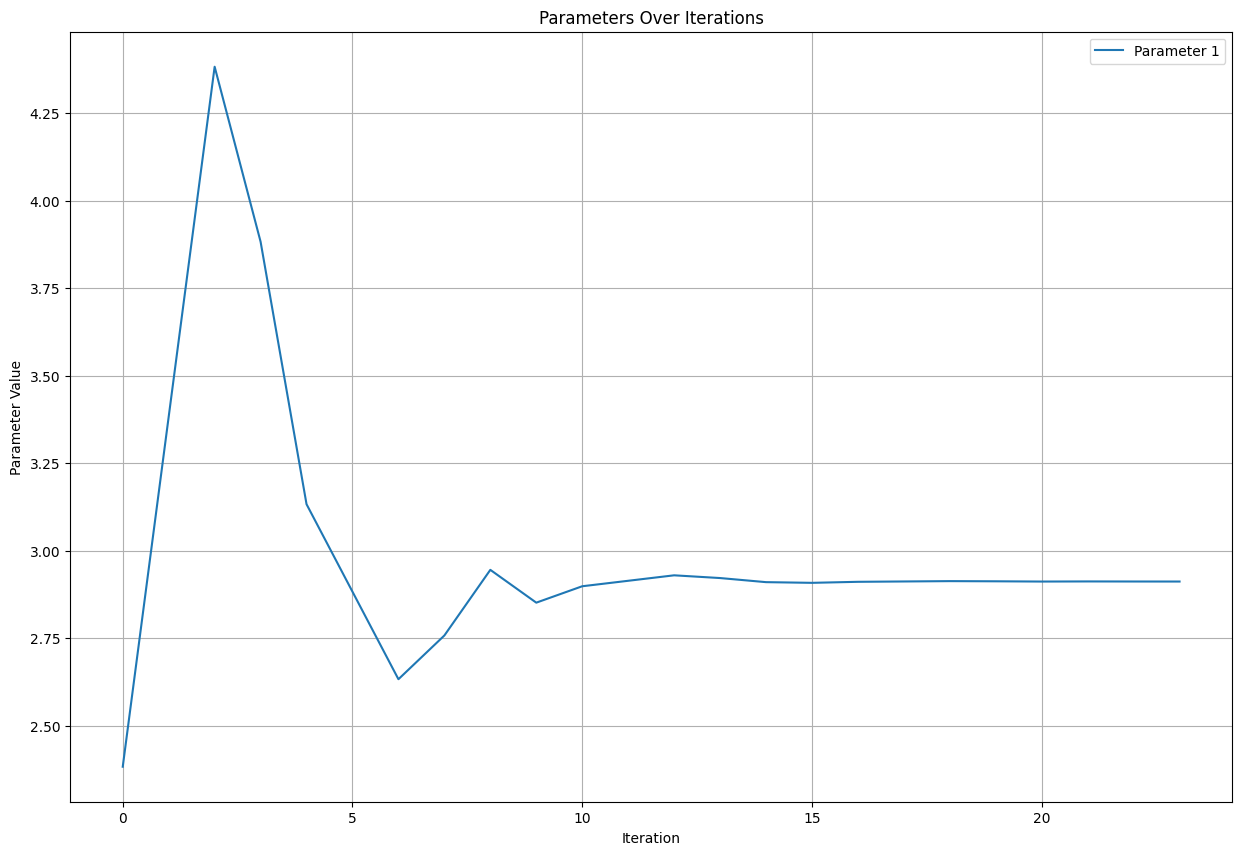

In [24]:
# Extract parameters
param_numbers = qc.num_parameters
data2 = cost_history_dict["parameters"]
iterations = range(len(data2))
# Extract all 16 parameters
parameters = [[row[i] for row in data2] for i in range(param_numbers)]
# Plotting the parameters
plt.figure(figsize=(15, 10))
# Plot each parameter
for i in range(param_numbers):
    plt.plot(iterations, parameters[i], label=f'Parameter {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import plot_state_city, plot_state_qsphere, plot_bloch_vector, plot_histogram
final_params = result.x[0]
print('final params: ', final_params)

qc = qc.assign_parameters({theta: final_params})

circ_op = Operator.from_circuit(qc)
circ_op.draw('latex')


final params:  2.9117248714107715


<IPython.core.display.Latex object>

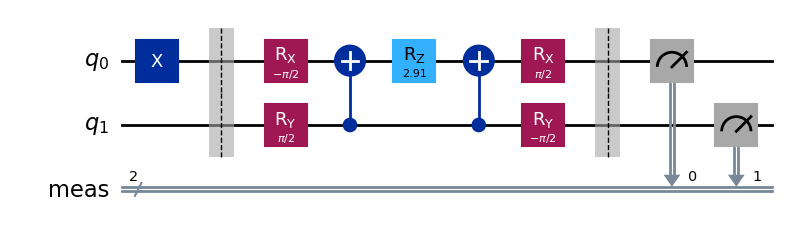

In [26]:
qc.measure_all()
qc.draw('mpl')

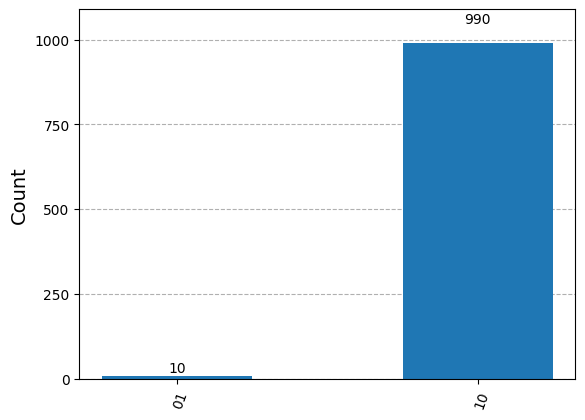

In [27]:
simluator = Aer.get_backend('qasm_simulator')

job_state = simluator.run(qc, shots=1000)

result = job_state.result()

counts = result.get_counts(qc)

plot_histogram(counts)


### Bell Measurements (Incomplete)

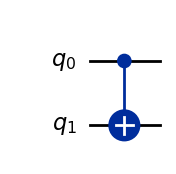

In [28]:
ubell = QuantumCircuit(2)
ubell.cx(0,1)
ubell_op = Operator.from_circuit(ubell)
ubell.draw('mpl')


In [29]:
ubell_op.draw('latex')

<IPython.core.display.Latex object>

In [30]:
ubell.h(0)
ubell_op = Operator.from_circuit(ubell)
ubell_op.draw('latex')

<IPython.core.display.Latex object>

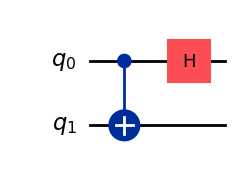

In [31]:
ubell.draw('mpl')

In [32]:
qc_superposition = QuantumCircuit(2)
qc_superposition.x(0)
qc_superposition.barrier()
qc_superposition.rx(param2,0)
qc_superposition.ry(param1,1)

qc_superposition.cx(1,0)

qc_superposition.rz(theta,0)

qc_superposition.cx(1,0)

qc_superposition.ry(param2,1)
qc_superposition.rx(param1,0)
qc_superposition.cx(0,1)
qc_superposition.h(0)
#qc_superposition.h(1)

qc_superposition = qc_superposition.assign_parameters({theta: final_params})
circ_bell_op = Operator.from_circuit(qc_superposition)

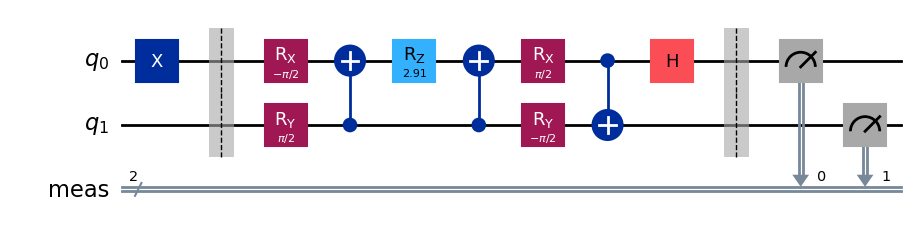

In [33]:
qc_superposition.measure_all()
qc_superposition.draw('mpl')

Counts in computational basis: {'01': 10, '10': 990}
Counts in superposition basis: {'10': 416, '11': 584}


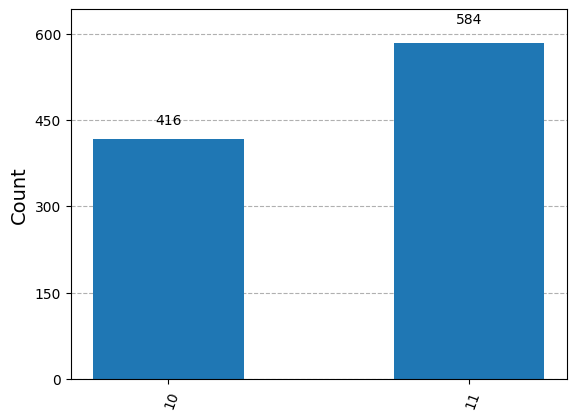

In [34]:
job_state_superposition = simluator.run(qc_superposition, shots=1000)

result_superpostion = job_state_superposition.result()

counts_superposition = result_superpostion.get_counts(qc_superposition)

print("Counts in computational basis:", counts)
print("Counts in superposition basis:", counts_superposition)
# Visualize results
plot_histogram(counts_superposition)

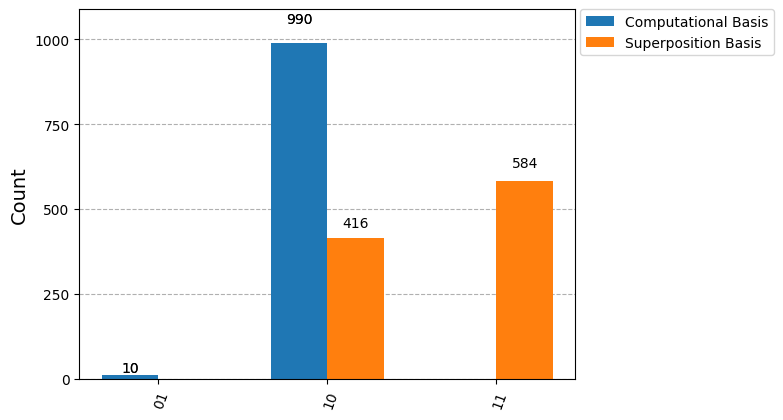

In [35]:
plot_histogram([counts, counts_superposition], legend=["Computational Basis", "Superposition Basis"])

###  Partial Tomography

In [36]:
from scipy.linalg import expm
def make_unitaryCirc(H):
    U = expm(1j * H)
    circuitU  = QuantumCircuit(int(np.log2(U.shape[0])))
    circuitU.unitary(U, range(int(np.log2(U.shape[0]))))  
    return circuitU

Pauliterms = ['II', 'ZI', 'IZ', 'ZZ', 'YY', 'XX']

coefficients = [g0, g1, g2, g3, g4, g5]


In [37]:
# measuring in the g_0 I basis

def make_full_circuit(pauli, params):

    qc = QuantumCircuit(2,2)

    qc.x(0)
    qc.barrier()
    qc.rx(param2,0)
    qc.ry(param1,1)
    qc.cx(1,0)
    qc.rz(theta,0)
    qc.cx(1,0)
    qc.ry(param2,1)
    qc.rx(param1,0)

    #compose local Hamiltonian    
    qc = qc.assign_parameters({theta: params.item() if isinstance(params, np.ndarray) else params})
    qc.barrier()
    if pauli == 'II':
        # Measure in the computational basis
        qc.measure([0, 1], [0, 1])
        # Doesnt do anything 
    elif pauli == 'ZI':
        # Measure first qubit in Z-basis, second qubit untouched
        qc.measure(1, 1)
    elif pauli == 'IZ':
        # Measure second qubit in Z-basis, first qubit untouched
        qc.swap(0,1)
        qc.measure(1,1)
    elif pauli == 'ZZ':
        # Measure both qubits in ZZ-basis
        #qc.measure([0, 1], [0, 1])
        qc.cx(0,1)
        qc.measure(1,0)
    elif pauli == 'YY':
        # Measure both qubits in Y-basis
        qc.h(0)
        qc.sdg(0)
        qc.h(1)
        qc.sdg(1)
        
        #qc.measure([0, 1], [0, 1])
        qc.cx(0,1)
        qc.measure(1,0)
    elif pauli == 'XX':
        # Measure both qubits in X-basis
        qc.h(0)
        qc.h(1)
        #qc.measure([0, 1], [0, 1])
        qc.cx(0,1)
        qc.measure(1,0)
    else:
        raise ValueError(f"Unsupported Pauli operator: {pauli}")
    
    return qc


In [38]:
shots = 1000 

expectation_values = {}
local_circuits = {}
def compute_expectation(counts, shots, verbal=False):
    """Compute expectation value from measurement counts."""
    exp_val = 0
    for bitstring, count in counts.items():
        if verbal:
            print('bitstring: ', bitstring)
            print('count: ', count)
        parity = bitstring.count('1') % 2  # Even=0 → +1, Odd=1 → -1 (eigenvlue and eigenstate of Pauli operators)
        exp_val += (-1) ** parity * (count / shots)
    return exp_val

for pauli in Pauliterms:
    meas_qc = make_full_circuit(pauli,final_params)
    local_circuits[pauli] = meas_qc
    transpiled_qc = transpile(meas_qc, simluator)
    job = simluator.run(transpiled_qc, shots=shots)
    counts = job.result().get_counts()

    # Special case for II, since it always has eigenvalues 1
    if pauli == 'II':
        exp_val = 1.0
    else:
        exp_val = compute_expectation(counts, shots)

    expectation_values[pauli] = exp_val



# Compute the Hamiltonian expectation value
H_expectation = sum(coeff * expectation_values[pauli] for coeff, pauli in zip(coefficients, Pauliterms))

print("Expectation values:", expectation_values)
print("Hamiltonian expectation:", H_expectation)

Expectation values: {'II': 1.0, 'ZI': -0.984, 'IZ': 0.976, 'ZZ': -1.0, 'YY': -0.19799999999999995, 'XX': -0.256}
Hamiltonian expectation: -1.8555852


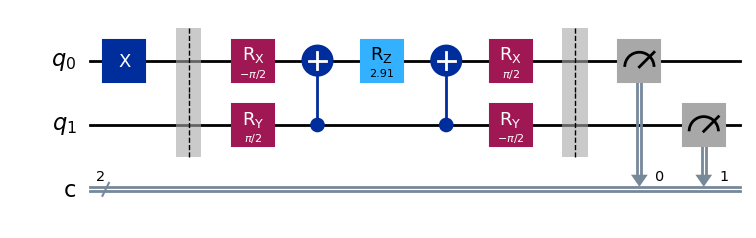

In [39]:
# Visualize the circuits
local_circuits['II'].draw('mpl')

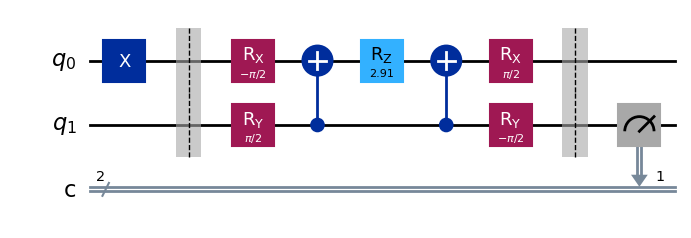

In [40]:
local_circuits['ZI'].draw('mpl')

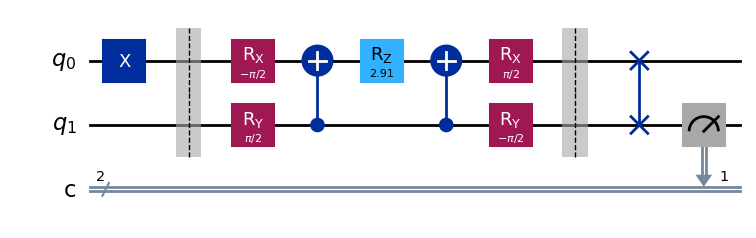

In [41]:
local_circuits['IZ'].draw('mpl')

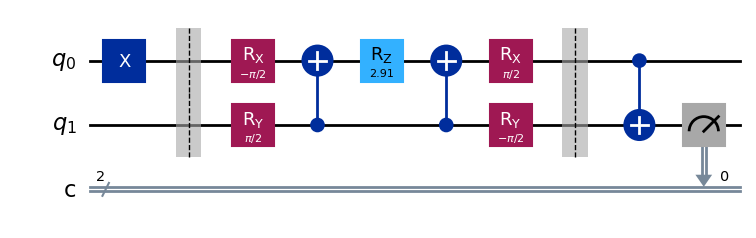

In [42]:
local_circuits['ZZ'].draw('mpl')

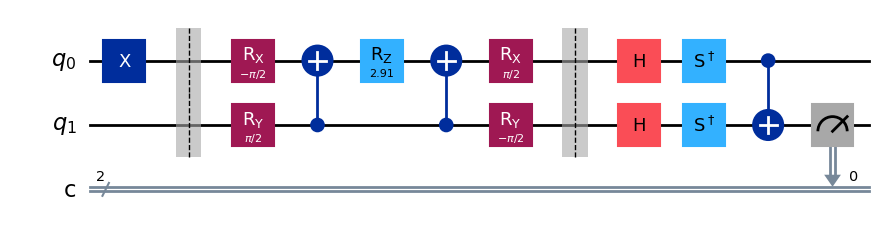

In [43]:
local_circuits['YY'].draw('mpl')

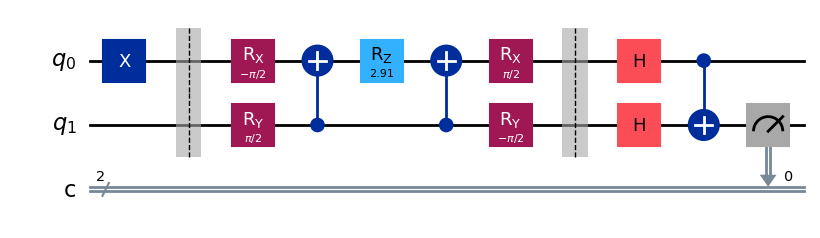

In [44]:
local_circuits['XX'].draw('mpl')

### Self-constructed cost-function/Optimization

In [ ]:
#optimization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "parameters": [],
    'II': {
        '00': [],
        '01': [],
        '10': [],
        '11': [],
        'exp': []
    }, 
    'ZI':{
        '00': [],
        '01': [],
        '10': [],
        '11': [],
        'exp': []
    }, 
    'IZ': {
        '00': [],
        '01': [],
        '10': [],
        '11': [],
        'exp': []
    },
    'ZZ':{
        '00': [],
        '01': [],
        '10': [],
        '11': [],
        'exp': []
    },
    'YY':{
        '00': [],
        '01': [],
        '10': [],
        '11': [],
        'exp': []
    }, 
    'XX': {
        '00': [],
        '01': [],
        '10': [],
        '11': [],
        'exp': []
    }
}
expectation_values = {}
local_circuits = {}
def cost_function(params): #cost function based on previously implemented partial tomography 
    for pauli in Pauliterms:
        meas_qc = make_full_circuit(pauli,params)
        local_circuits[pauli] = meas_qc
        transpiled_qc = transpile(meas_qc, simluator)
        job = simluator.run(transpiled_qc, shots=shots)
        counts = job.result().get_counts()

        # Special case for II, since it always has eigenvalues 1
        if pauli == 'II':
            exp_val = 1.0
        else:
            exp_val = compute_expectation(counts, shots, verbal=False)

        expectation_values[pauli] = exp_val
        # Store counts and expectation values in cost_history_dict
        for bitstring, count in counts.items():
            cost_history_dict[pauli][bitstring].append(count)
        cost_history_dict[pauli]['exp'].append(exp_val)
        

    # Compute the Hamiltonian expectation value 
    H_expectation = sum(coeff * expectation_values[pauli] for coeff, pauli in zip(coefficients, Pauliterms))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(H_expectation)
    cost_history_dict["parameters"].append(params)
    return H_expectation

def constraint(params): 
    return np.pi - params

#Optimization
result = minimize(cost_function, initial_params_h2.item(), method='COBYLA', constraints={'type': 'ineq', 'fun': constraint}, options={'maxiter': 12000})
print(result)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8380948
       x: [ 2.962e+00]
    nfev: 18
   maxcv: 0.0


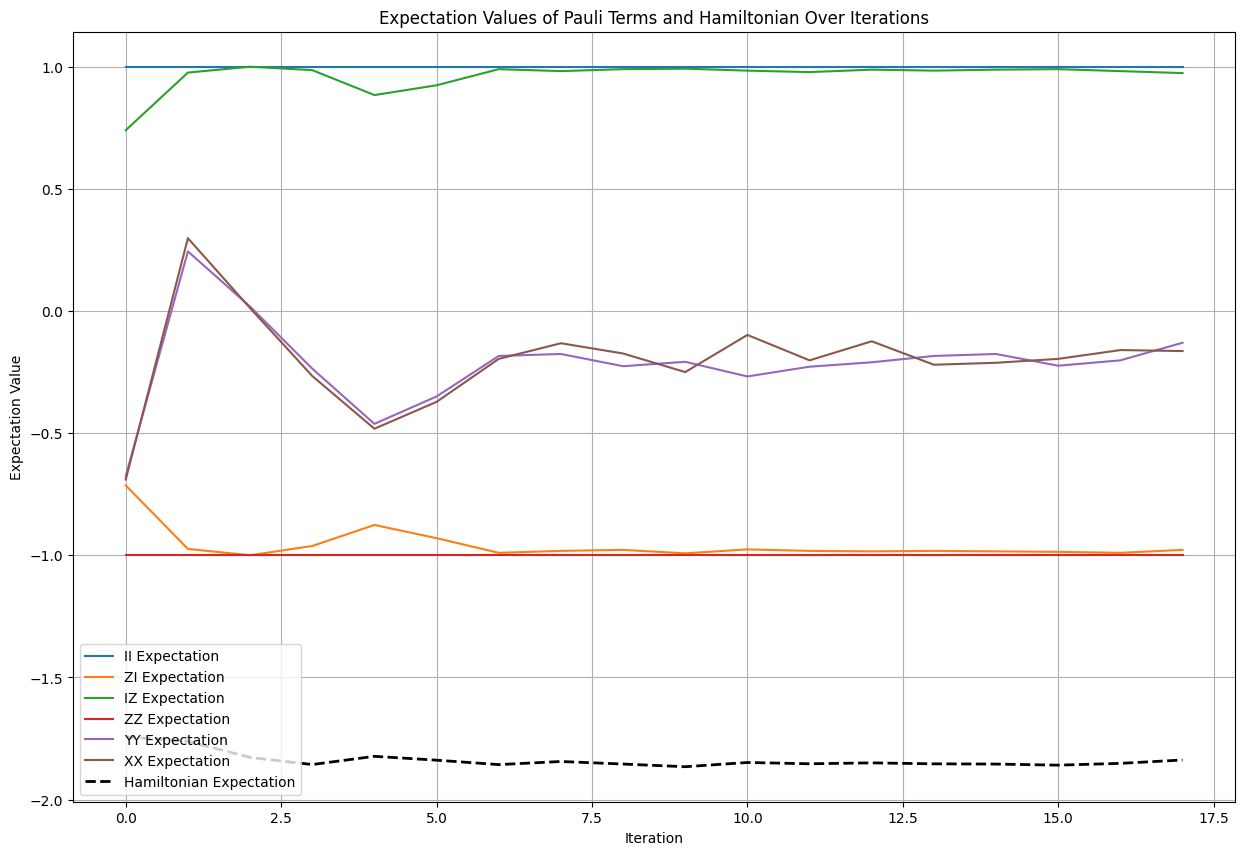

In [46]:
# Extract iterations
iterations = range(cost_history_dict["iters"])

# Plot the expectation values for each Pauli term
plt.figure(figsize=(15, 10))
for pauli in Pauliterms:
    plt.plot(iterations, cost_history_dict[pauli]['exp'], label=f'{pauli} Expectation')

# Plot the overall Hamiltonian expectation value
plt.plot(iterations, cost_history_dict["cost_history"], label='Hamiltonian Expectation', linewidth=2, linestyle='--', color='black')

# Add labels, title, and legend
plt.xlabel('Iteration')
plt.ylabel('Expectation Value')
plt.title('Expectation Values of Pauli Terms and Hamiltonian Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

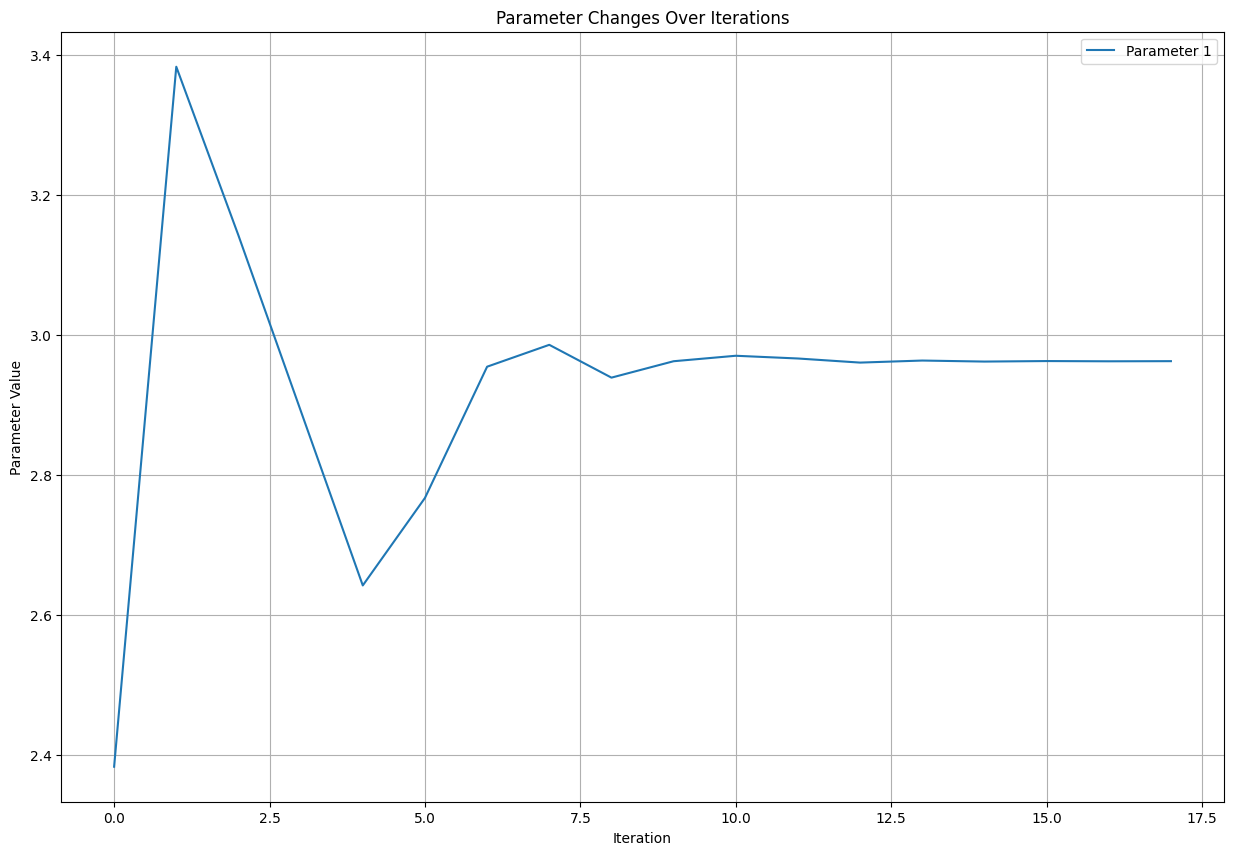

In [47]:
# Extract iterations
iterations = range(cost_history_dict["iters"])

# Extract parameters
parameters = cost_history_dict["parameters"]

# Plot the parameters over iterations
plt.figure(figsize=(15, 10))
for i in range(len(parameters[0])):
    param_values = [param[i] for param in parameters]
    plt.plot(iterations, param_values, label=f'Parameter {i+1}')

# Add labels, title, and legend
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameter Changes Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

### Using Quantum Ring SDK

In [48]:

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2   
import warnings
with open('token.txt', 'r') as file:
    token = file.read().strip()

provider = QuantumRingsProvider(
    token=token,
    name='snguyen7@stevens.edu'
)
provider.active_account()

warnings.filterwarnings("ignore")

In [49]:

expectation_values = {}
local_circuits = {}

for pauli in Pauliterms:
    meas_qc = make_full_circuit(pauli,final_params)
    mybackend = QrBackendV2(provider, num_qubits = meas_qc.num_qubits)
    local_circuits[pauli] = meas_qc
    qc_transpiled = transpile(meas_qc, mybackend, initial_layout=[i for i in range(0, meas_qc.num_qubits)])
    job = mybackend.run(qc_transpiled, shots = shots)
    result = job.result()
    counts = result.get_counts()

    # Special case for II, since it always has eigenvalues 1
    if pauli == 'II':
        exp_val = 1.0
    else:
        exp_val = compute_expectation(counts, shots,verbal=False)

    expectation_values[pauli] = exp_val

H_expectation = sum(coeff * expectation_values[pauli] for coeff, pauli in zip(coefficients, Pauliterms))

print("Expectation values:", expectation_values)
print("Hamiltonian expectation:", H_expectation)


Expectation values: {'II': 1.0, 'ZI': -0.976, 'IZ': 0.982, 'ZZ': -1.0, 'YY': -0.25, 'XX': -0.244}
Hamiltonian expectation: -1.8590853999999999
